# Assignment 2: Color Constancy, Shadows Removal, or Intrinsic Imaging 
### Course: CS 7180
### Authors: Gourav Beura and Heet Sakaria

### Import Dependencies

In [1]:
import cv2
import numpy as np
import tensorflow as tf

In [2]:
from tensorflow import keras
from keras import optimizers
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.initializers import glorot_uniform
from keras import backend as K
from generate_data import generate_train_data, generate_test_data;

In [3]:
import os

In [4]:
import scipy.io

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

## Model Training on Ghelar's Dataset

### Step 1: Prepare Dataset
The implementation for preparing dataset is mentioned in the prepare_dataset.py

### Step 2: Model Defination

In [69]:
def ColorNet(in_shape, channels = 3):
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(in_shape)
    
    # Stage 1
    X = Conv2D(240, (1, 1), strides = (1, 1), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X_input)
    X = BatchNormalization(name = 'bn_conv1')(X)
    X = MaxPooling2D((8, 8), strides=(8, 8))(X)
    
    # output layer
    X = Flatten()(X)
    X = Dense(40, activation='relu', name='fc' + str(40))(X)
    X = Dropout(rate = 0.5)(X)
    
    X = Dense(channels, activation=None, name='fc' + str(channels))(X);
    
    # Create model
    color_model = Model(inputs = X_input, outputs = X, name='ColorNet')
    
    return color_model

### Step 3: Generate Train and Test Data

In [70]:
X_train, Y_train, _ = generate_train_data(train_size = 9000, set_name = 'Shi-Gehler', patch_size = (32, 32))

Generating Training Data :: 100% [==============================] Time: 0:00:22


In [71]:
X_test, Y_test, _ = generate_test_data(test_size = 2420, set_name = 'Shi-Gehler', patch_size = (32, 32))

Generating Testing Data :: 100% [===============================] Time: 0:00:10


### Step 4: Model Fit 

In [72]:
loss_cos_sim = tf.keras.losses.CosineSimilarity()

In [100]:
model = ColorNet(in_shape = X_train.shape[1:4])
model.compile(optimizer='Adam',loss=loss_cos_sim,metrics = ['accuracy'])
model.fit(X_train,Y_train,validation_split = 0.3333, epochs = 30, batch_size = 64)        

Epoch 1/30
90/90 [==============================] - 5s 43ms/step - loss: -0.9178 - accuracy: 0.7321 - val_loss: -0.9843 - val_accuracy: 0.9464
Epoch 2/30
90/90 [==============================] - 3s 31ms/step - loss: -0.9653 - accuracy: 0.8715 - val_loss: -0.9863 - val_accuracy: 0.9464
Epoch 3/30
90/90 [==============================] - 3s 31ms/step - loss: -0.9777 - accuracy: 0.9282 - val_loss: -0.9862 - val_accuracy: 0.9464
Epoch 4/30
90/90 [==============================] - 3s 31ms/step - loss: -0.9827 - accuracy: 0.9407 - val_loss: -0.9861 - val_accuracy: 0.9464
Epoch 5/30
90/90 [==============================] - 3s 31ms/step - loss: -0.9844 - accuracy: 0.9489 - val_loss: -0.9867 - val_accuracy: 0.9464
Epoch 6/30
90/90 [==============================] - 3s 31ms/step - loss: -0.9863 - accuracy: 0.9506 - val_loss: -0.9871 - val_accuracy: 0.9464
Epoch 7/30
90/90 [==============================] - 3s 31ms/step - loss: -0.9868 - accuracy: 0.9515 - val_loss: -0.9875 - val_accuracy: 0.9464

### Step 5: Save Model

In [ ]:
model_json = model.to_json()
model_dir = os.path.join(os.getcwd(),'saved_model')
print(model_dir)
with open("cc_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("cc_model.h5")

print("Saved model to disk")

## Model Inference Endpoints

In [6]:
import cv2
from keras.models import model_from_json

In [7]:
from utils import load_groundtruth_illuminant,get_images_fullpath
from gamma_linearization import gamma_decode, gamma_encode
from prepare_dataset import white_balance_image,convert_to_8bit

In [53]:
def ccnet_create_illumination_map(image,patch_size):
    """
    This method loads the trained model and uses local image patches to generate illuminatation estimates for the input image
    Args:
        img (np.array): input (linear) image
        patch_size: size of local patches
    Returns:
        estimated illumination map
    """
     #load cc_model
    model_dir = os.path.join(os.getcwd(),'saved_model')
    colornet_json_path = os.path.join(model_dir,'colornet_model.json')
    # colornet_json_path = os.path.join(os.getcwd(),'colornet_model.json')
    # print(colornet_json_path)
    json_file = open('cc_model.json', 'r')
    # json_file = open(colornet_json_path, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    
    
    loss_cos_sim = tf.keras.losses.CosineSimilarity()
    colornet_model = model_from_json(loaded_model_json)
    
    # colornet_wt_path = os.path.join(model_dir,'colornet_model.h5')
    colornet_model.load_weights("cc_model.h5")
    # colornet_model.load_weights(colornet_wt_path)
    colornet_model.compile(optimizer='Adam', loss=loss_cos_sim, metrics = ['accuracy'])
    
    n_r, n_c, _ = image.shape
    patch_r, patch_c = patch_size
    
    total_patch = int(((n_r - n_r%patch_r)/patch_r)*((n_c - n_c%patch_c)/patch_c))
    
    img_resize = cv2.resize(image, ((n_r - n_r%patch_r), (n_c - n_c%patch_c)))
    img_reshape = np.reshape(img_resize, (int(patch_r), -1, 3))
    
    illum_estimate = []
    print('Before processing total patches')
    for i in range(total_patch):    
        img_patch = img_reshape[0:patch_r, i*patch_c:(i+1)*patch_c]
        patch_cvt = cv2.cvtColor(img_patch, cv2.COLOR_BGR2RGB)
        patch_cvt = np.expand_dims(patch_cvt, axis=0)
        illum_estimate.append(colornet_model.predict(patch_cvt))
    illum_estimate = np.asarray(illum_estimate)
    illum_map = np.reshape(illum_estimate, (int((n_r - n_r%patch_r)/patch_r), int((n_c - n_c%patch_c)/patch_c), 3))
    print('generated illum_map')
    return illum_map

In [54]:
def pool_function(illum_map, pool_size, stride,  mode):
    print('Inside pool_function')
    n_h, n_w, n_c = illum_map.shape
    pool_h, pool_w = pool_size
    stride_h, stride_w = stride
    
    # Define the dimensions of the output
    h_out = int(1 + (n_h - pool_h) / stride_h)
    w_out = int(1 + (n_w - pool_w) / stride_w)
    c_out = n_c
    
    pool_out = np.zeros((h_out, w_out, c_out))
    
    for h in range(h_out):                     
        for w in range(w_out):                 
            for c in range (c_out):            
                
                vert_start = h*stride_h
                vert_end = h*stride_h + pool_h
                horiz_start = w*stride_w
                horiz_end = w*stride_w + pool_w
                    
                slice_window = illum_map[vert_start:vert_end, horiz_start:horiz_end, c]
                    
                if mode == "std":
                    pool_out[h, w, c] = np.std(slice_window)
                elif mode == "average":
                    pool_out[h, w, c] = np.mean(slice_window)
    print('Exit pool_function')
    return pool_out

In [55]:
def local_2_global(image_name, image, patch_size):
    """
    This method returns average of all image patches estimated by the ColorNet model
    """
    print('Inside local_2_global')
    n_r, n_c, _ = image.shape
    
    illum_map = ccnet_create_illumination_map(image, patch_size)      #patch_size = (32, 32)
    
    #Gaussian Smooting with 5x5 kernel
    illum_map_smoothed = cv2.GaussianBlur(illum_map, (5,5), cv2.BORDER_DEFAULT)
    
    #Perform median pooling
    median_pooling = np.zeros((1, 3))
    median_pooling[0, 0] = np.median(illum_map_smoothed[:, :, 0])
    median_pooling[0, 1] = np.median(illum_map_smoothed[:, :, 1])
    median_pooling[0, 2] = np.median(illum_map_smoothed[:, :, 2])
        
    #Perform avarage pooling 
    n_r, n_c, _ = illum_map.shape
    pool_size = (int(n_r/3), int(n_c/3))
    stride = (int(n_r/3), int(n_c/3))
    average_pooling = pool_function(illum_map, pool_size, stride, mode = 'average')
    
    average_pooling[0, 0] = np.mean(average_pooling[:, :, 0])
    average_pooling[0, 1] = np.mean(average_pooling[:, :, 1])
    average_pooling[0, 2] = np.mean(average_pooling[:, :, 2])
    

    illum_global = median_pooling
    print('Exit local_2_global')
    return illum_global
    

In [56]:
def colornet_white_balancing(img, image_name, patch_size):
    """
    This is an abstract method that performs white balancing using the illumation estimate map generated by the ColorNet model
    """
    print('Inside white_balancing')
    m, n, _ = img.shape
    B_channel, G_channel, R_channel = cv2.split(img)
    Color_space = 'AdobeRGB'
 
    #Undo Gamma Correction
    print('Performing  Gamma Correction')
    B_channel, G_channel, R_channel = gamma_decode(B_channel, G_channel, R_channel, Color_space)
    
    #Compute local illuminant map then aggregate to global illuminant
    print('Started local illuminant map then aggregate to global illuminant')
    illum_global = local_2_global(image_name, img, patch_size)
    print('Ended local illuminant map then aggregate to global illuminant')  
    
    #Gain of red and  blue channels
    alpha = np.max(illum_global)/illum_global[0, 2]
    beta = np.max(illum_global)/illum_global[0, 1]
    ceta = np.max(illum_global)/illum_global[0, 0]
        
    #Corrected Image
    B_cor = alpha*B_channel
    G_cor = beta*G_channel
    R_cor = ceta*R_channel
        
    #Gamma correction to display
    B_cor, G_cor, R_cor = gamma_encode(B_cor, G_cor, R_cor, Color_space)
    B_cor[B_cor > 255] = 255
    G_cor[G_cor > 255] = 255
    R_cor[R_cor > 255] = 255
        
    #Convert to uint8 to display
    B_cor = B_cor.astype(np.uint8)
    G_cor = G_cor.astype(np.uint8)
    R_cor = R_cor.astype(np.uint8)
    img_cor = cv2.merge((B_cor, G_cor, R_cor))
    
    return img_cor

### Visualize Output

In [57]:
real_rgb = load_groundtruth_illuminant('C:\\Users\\Skyfire\\source\\repos\\CNN_model_ColorConstancy\\Dataset\\Shi_Gehler\\gt\\real_illum_568.mat')

In [58]:
db_images = get_images_fullpath(img_folder_path = 'C:\\Users\\Skyfire\\source\\repos\\CNN_model_ColorConstancy\\Dataset\\Shi_Gehler\\png1\\')
db_images = db_images[:86] #Canon1D images

In [59]:
test_image_indexs = np.random.choice(len(db_images), 8) #Picked 8 random images

In [60]:
input_imgs = []
gt_imgs = []
cnn_imgs = []

In [61]:
def get_input_image(img12,bit):
    img12 = (img12/(2**bit - 1))*100.0; #12bit data
    image = convert_to_8bit(img12, 2.5)
    image = (cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    gamma = 1/2.2
    image = pow(image, gamma) * (255.0/pow(255,gamma))
    image = np.array(image,dtype=np.uint8)
    image8 = (cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    return image8

### Generate colornet output images

In [17]:
%time
bit = 12
patch_size = (32,32)
for it,idx in enumerate(test_image_indexs):
    print(f'---------------- Start of Iteration: {it+1} ----------------')
    # Step 1: Convert 12-bit images to 8-bit images
    img12 = cv2.imread(db_images[idx],cv2.IMREAD_UNCHANGED).astype(np.float32)
    img12 = cv2.resize(img12, (512, 512))
    inp_image = get_input_image(img12.copy(),bit=bit)
    input_imgs.append(inp_image)
    
    # Step 2: Generate Ground truth
    Gain_R= float(np.max(real_rgb[idx]))/float((real_rgb[idx][0]))
    Gain_G= float(np.max(real_rgb[idx]))/float((real_rgb[idx][1]))
    Gain_B= float(np.max(real_rgb[idx]))/float((real_rgb[idx][2]))
    gt_image = white_balance_image(img12, bit, Gain_R, Gain_G, Gain_B)
    gt_imgs.append(gt_image)
    
    #Step 3: Generate ColorNet output
    out_img = colornet_white_balancing(inp_image, 'test', patch_size)
    cnn_imgs.append(out_img)
    print(f'---------------- End of Iteration: {it+1} ----------------')


CPU times: total: 0 ns
Wall time: 0 ns
---------------- Start of Iteration: 1 ----------------
Inside white_balancing
Performing  Gamma Correction
Started local illuminant map then aggregate to global illuminant
Inside local_2_global
Before processing total patches
generated illum_map
Inside pool_function
Exit pool_function
Exit local_2_global
Ended local illuminant map then aggregate to global illuminant
---------------- End of Iteration: 1 ----------------
---------------- Start of Iteration: 2 ----------------
Inside white_balancing
Performing  Gamma Correction
Started local illuminant map then aggregate to global illuminant
Inside local_2_global
Before processing total patches
generated illum_map
Inside pool_function
Exit pool_function
Exit local_2_global
Ended local illuminant map then aggregate to global illuminant
---------------- End of Iteration: 2 ----------------
---------------- Start of Iteration: 3 ----------------
Inside white_balancing
Performing  Gamma Correction
Start

### Plot the images

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\Skyfire\AppData\Local\Temp\ipykernel_24016\3786341763.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


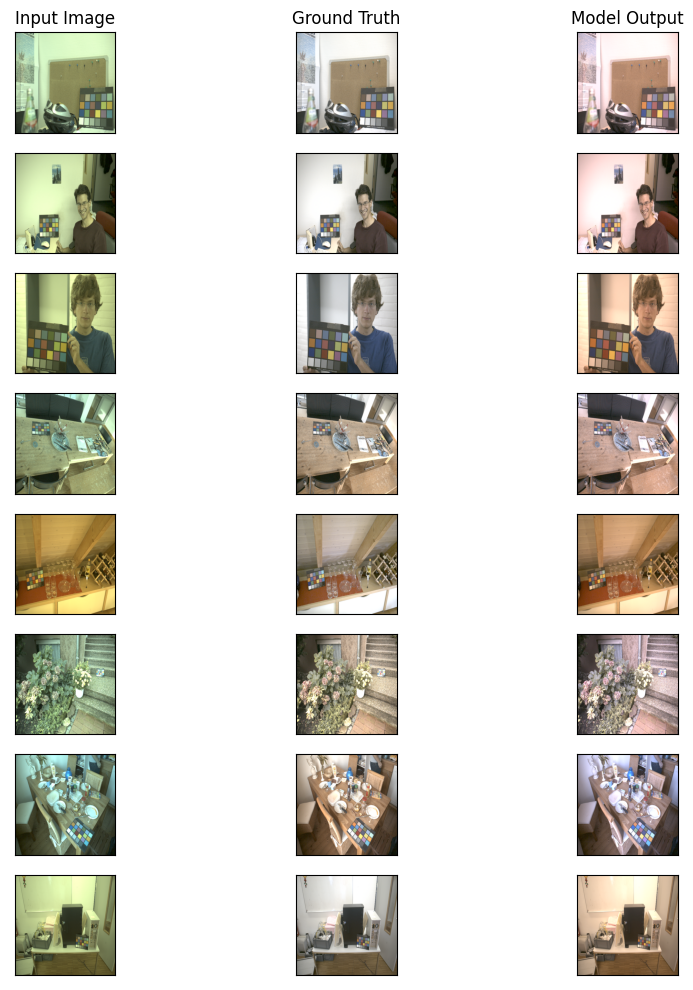

In [28]:
k=1
fig = plt.figure(figsize=(10,10))
for i in range(len(input_imgs)):
    plt.subplot(8,3,k)
    if k==1:
        plt.title("Input Image")
    plt.imshow(cv2.cvtColor(input_imgs[i], cv2.COLOR_BGR2RGB))
    k+=1
    plt.xticks([])
    plt.yticks([])
    plt.subplot(8,3,k)

    if k==2:
        plt.title("Ground Truth")
    plt.imshow(cv2.cvtColor(gt_imgs[i], cv2.COLOR_BGR2RGB))
    k+=1
    plt.xticks([])
    plt.yticks([])
    plt.subplot(8,3,k)
    if k==3:
        plt.title("Model Output")
    plt.imshow(cv2.cvtColor(cnn_imgs[i], cv2.COLOR_BGR2RGB))
    k+=1
    plt.xticks([])
    plt.yticks([])
fig.tight_layout()
# fig.title("Input Image - Ground Truth - Model Output")
fig.show()